## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pydotplus
import graphviz

%matplotlib inline

from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from IPython.display import SVG, display

## Loading data

In [2]:
boston_dataset = load_boston()
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_df['MEDV'] = boston_dataset.target

print(boston_dataset.DESCR)
boston_df.head()

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Cleaning data

In [3]:
boston_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Explore data

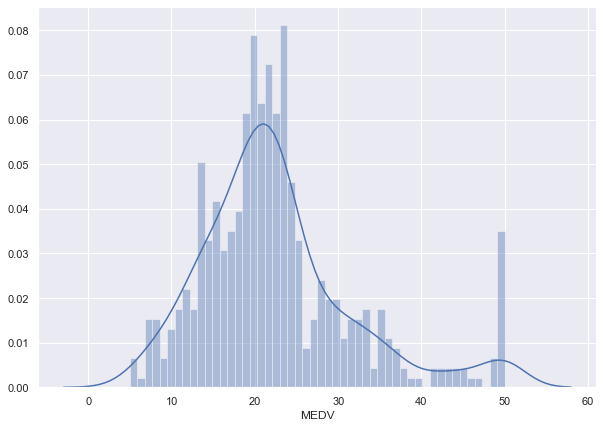

In [4]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.distplot(boston_df['MEDV'], bins=50)
plt.show()

(14, 0)

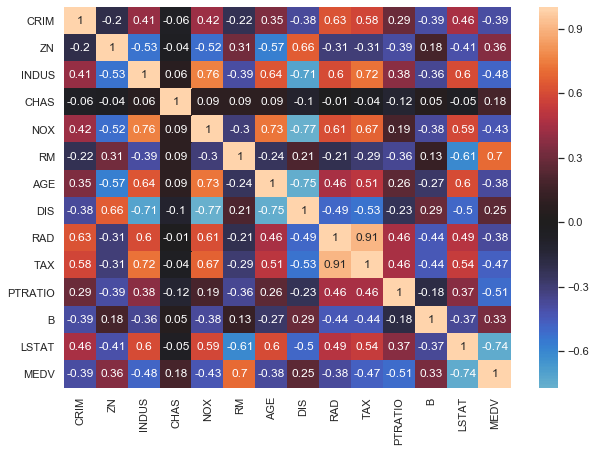

In [5]:
corr_mat = boston_df.corr().round(2)
ax = sns.heatmap(data=corr_mat, annot=True, center=0)
ax.set_ylim(14, 0)

In [6]:
X = boston_df[['RM', 'PTRATIO', 'LSTAT']].values
y = boston_df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Gradient Boosting algo

Step 1: Calculate average of target

In [7]:
avg_price = y_train.mean()
avg_price

22.339830508474574

Step 2: Calculate Pseudo-residual

In [8]:
res_0 = y_train - avg_price
res_0[:10]

array([-1.93983051, -6.33983051, -9.03983051,  8.46016949,  5.16016949,
        2.06016949,  2.06016949,  2.76016949, 21.46016949, -0.43983051])

Calculate error

In [9]:
mae_0 = np.absolute(res_0).mean()
mae_0

6.5473666570908735

Step 3: Build the first tree

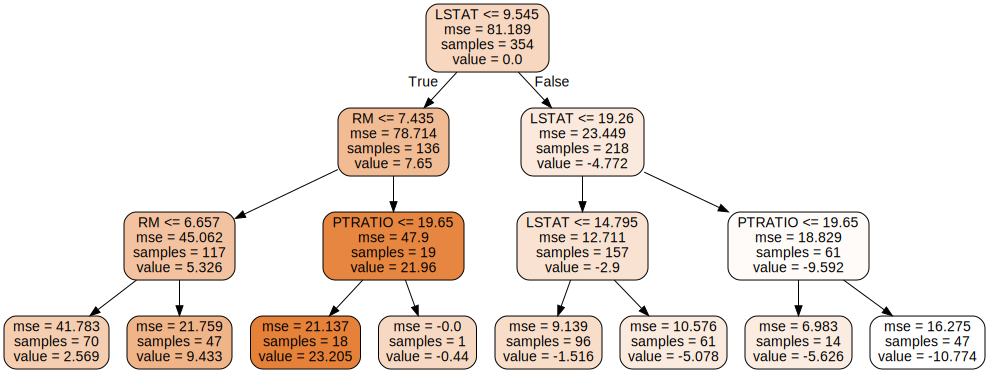

In [10]:
MAX_DEPTH = 3
MAX_LEAF_NB = 8

dtree_1 = DecisionTreeRegressor(max_depth=MAX_DEPTH, max_leaf_nodes=MAX_LEAF_NB)

# Fit a tree to predict the residual
dtree_1.fit(X_train, res_0)

# Display tree
exp_tree = export_graphviz(
    dtree_1, 
    out_file=None, 
    feature_names=['RM', 'PTRATIO', 'LSTAT'],
    filled = True,
    rounded=True
)
graph = graphviz.Source(exp_tree)
display(SVG(graph.pipe(format='svg')))

Step 4: Compute prediction

In [11]:
LEARNING_RATE = 0.1

# Predict the pseudo residual 0 for the training data
res_0_hat = dtree_1.predict(X_train)

# Compute prediction
pred_1 = avg_price + LEARNING_RATE * res_0_hat

# Compute pseudo residual 1
res_1 = y_train - pred_1

# Calculate error
mae_1 = np.absolute(res_1).mean()
mae_1

6.044337003131671

Let's automate the process to add n trees

In [57]:
class GradientBoostingRegressor(object):
    
    def __init__(self, lr, max_depth, max_leaf_nb):
        # Learning rate
        self.lr = lr
        # Maximum depth for the trees
        self.max_depth = max_depth
        # Maximum number of leafs for the trees
        self.max_leaf_nb = max_leaf_nb
        
        # Average of target
        self.avg = None
        
        # Decision Trees
        self.trees = []
        
        # Mean absolute errors
        self.mae_train = []
        self.mae_val = []
        
    def compute_pred(self, X):
        pred = self.avg
        for t in self.trees:
            # Predict the pseudo residual for the training data
            res_hat = t.predict(X)

            # Compute prediction
            pred += self.lr * res_hat
            
        return pred
    
    def fit(self, X_train, y_train, X_val, y_val, nb_trees, early_stopping_nb=None):
        # Calculate average
        if self.avg is None:
            self.avg = y_train.mean()

        # Calculate initial pseudo residual
        res_train = y_train - self.avg

        # Add trees
        best_mae = 999999
        last_improv = 0
        for n in range(nb_trees):
            # Create a new tree
            self.trees.append(DecisionTreeRegressor(max_depth=self.max_depth, max_leaf_nodes=self.max_leaf_nb))

            # Fit the tree to predict the residual
            self.trees[-1].fit(X_train, res_train)

            # Compute the prediction for training
            pred_train = self.compute_pred(X_train)

            # Compute pseudo residual
            res_train = y_train - pred_train
            
            # Compute the prediction for validition
            pred_val = self.compute_pred(X_val)
            res_val = y_val - pred_val

            # Calculate error
            self.mae_train.append(np.absolute(res_train).mean())
            self.mae_val.append(np.absolute(res_val).mean())

            print(f'GB with {n + 1} trees: MAE = {self.mae_val[-1]}')
            
            if early_stopping_nb is not None:
                # Check for improvment
                if self.mae_val[-1] < best_mae:
                    best_mae = self.mae_val[-1]
                    last_improv = n
                
                if n - last_improv >= early_stopping_nb:
                    print(f'No improvement since {last_improv + 1}th tree.')
                    print(f'Stopping training and saving model with {last_improv + 1} trees and MAE score of {best_mae}.')
                    self.trees = self.trees[:last_improv + 1]
                    return
                
    def mae_graph(self):
        plt.plot(range(len(self.mae_train)), self.mae_train, label='train')
        plt.plot(range(len(self.mae_val)), self.mae_val, label='val')
        plt.legend()
        plt.show()

GB with 1 trees: MAE = 6.235628296981205
GB with 2 trees: MAE = 5.804000838968024
GB with 3 trees: MAE = 5.417640212858939
GB with 4 trees: MAE = 5.0922027263374785
GB with 5 trees: MAE = 4.8013559707731
GB with 6 trees: MAE = 4.539690159001887
GB with 7 trees: MAE = 4.3087307374429
GB with 8 trees: MAE = 4.0943601704988195
GB with 9 trees: MAE = 3.9152029811572944
GB with 10 trees: MAE = 3.7661829944406318
GB with 11 trees: MAE = 3.607963657064597
GB with 12 trees: MAE = 3.4844759465884194
GB with 13 trees: MAE = 3.366881569709872
GB with 14 trees: MAE = 3.261908991692923
GB with 15 trees: MAE = 3.1744352336335115
GB with 16 trees: MAE = 3.109492411632137
GB with 17 trees: MAE = 3.039713206270635
GB with 18 trees: MAE = 2.9650368416199444
GB with 19 trees: MAE = 2.9107189405280347
GB with 20 trees: MAE = 2.870400825275663
GB with 21 trees: MAE = 2.8241866912630416
GB with 22 trees: MAE = 2.788050397534208
GB with 23 trees: MAE = 2.766039500791624
GB with 24 trees: MAE = 2.739825589522

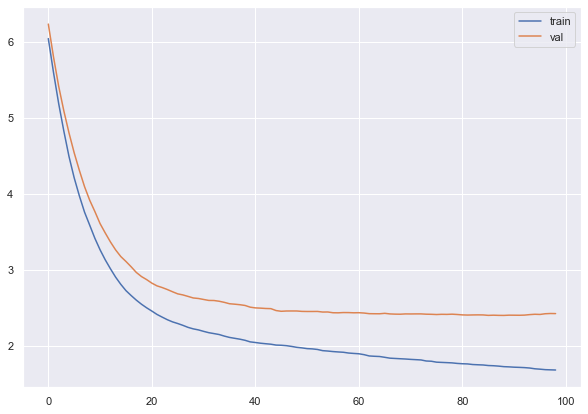

In [58]:
gbm = GradientBoostingRegressor(LEARNING_RATE, MAX_DEPTH, MAX_LEAF_NB)
gbm.fit(X_train, y_train, X_test, y_test, 300, early_stopping_nb=10)
gbm.mae_graph()